In [8]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from configs.RecursiveVPSDE.Markovian_8DLorenz.recursive_Markovian_PostMeanScore_8DLorenz_Stable_T256_H05_tl_110data_StbleTgt import get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
config = get_config()
num_paths = 1024 if config.feat_thresh == 1. else 10240
assert num_paths == 1024
root_dir = "/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModels/"

In [10]:
def get_drift_files(config, root_dir ):
    ts_type = f"{config.ndims}DLnz"
    include = (f"_{num_paths}NPaths_{config.t0}t0_{config.deltaT:.3e}dT_").replace(".", "")
    root_nadaraya_dir = root_dir + f"ExperimentResults/Nadaraya/8DLnzLessData/"
    true_files = []
    local_files = []
    for file in os.listdir(root_nadaraya_dir):
        if "IIDNadaraya" in file and ts_type in file and include in file and ((f"{config.forcing_const}FConst").replace(".","") in file):
            if "true" in file:
                true_files.append(root_nadaraya_dir+file)
            elif "global" in file:
                local_files.append(root_nadaraya_dir+file)
            elif "MSEs" in file and "bwidx" not in file:
                mses_full = pd.read_parquet(root_nadaraya_dir+file)
                mses_full = mses_full.rename({"bw":"_bw"}, axis=1)
                mses_full["bw"] = mses_full["_bw"].apply(lambda x: x[0])
                mses = mses_full.drop("_bw", axis=1)[["bw", "mse"]].sort_values("bw", axis=0)
    print(mses)
    assert len(true_files)>0, "No true files found"
    assert len(local_files)>0, "No local files found"
    assert (len(true_files) == len(local_files))
    def extract_bw_number(s):
        match = s.split("/")[-1].split("_")[3][:-2]
        return float("0." + match)
    true_files = sorted(true_files, key=extract_bw_number)
    local_files = sorted(local_files, key=extract_bw_number)
    bws = [extract_bw_number(f) for f in true_files]
    return true_files, local_files, bws, mses

In [11]:
config = get_config()
true_files, local_files, bws, mses = get_drift_files(config=config, root_dir=root_dir)
len(mses)

              bw          mse
0       0.000282          NaN
1       0.000372          NaN
2       0.000491          NaN
3       0.000649          NaN
4       0.000857          NaN
5       0.001131          NaN
6       0.001493  2030.242521
7       0.001972  3257.399602
8       0.002603  2210.687102
9       0.003437  1756.661594
10      0.004538  1896.645925
11      0.005992  2022.471700
12      0.007912  2204.492559
13      0.010446  2429.971083
14      0.013793  2642.925321
15      0.018211  2788.321404
16      0.024046  2848.873453
17      0.031749  2915.609897
18      0.041919  2770.806529
19      0.055348  2545.811079
20      0.073079  2249.601324
21      0.096490  1943.392461
22      0.127401  1594.518133
23      0.168214  1273.791014
24      0.222102  1037.306393
25      0.293252   890.454554
26      0.387196   809.254849
27      0.511235   767.572103
28      0.675010   740.049834
29      0.891251   713.632604
30      1.135011   687.973691
31      1.445440   657.071143
32      1.

60

Text(0.5, 1.0, 'Minimum MSE is (10000.0, 419.6202253434292)')

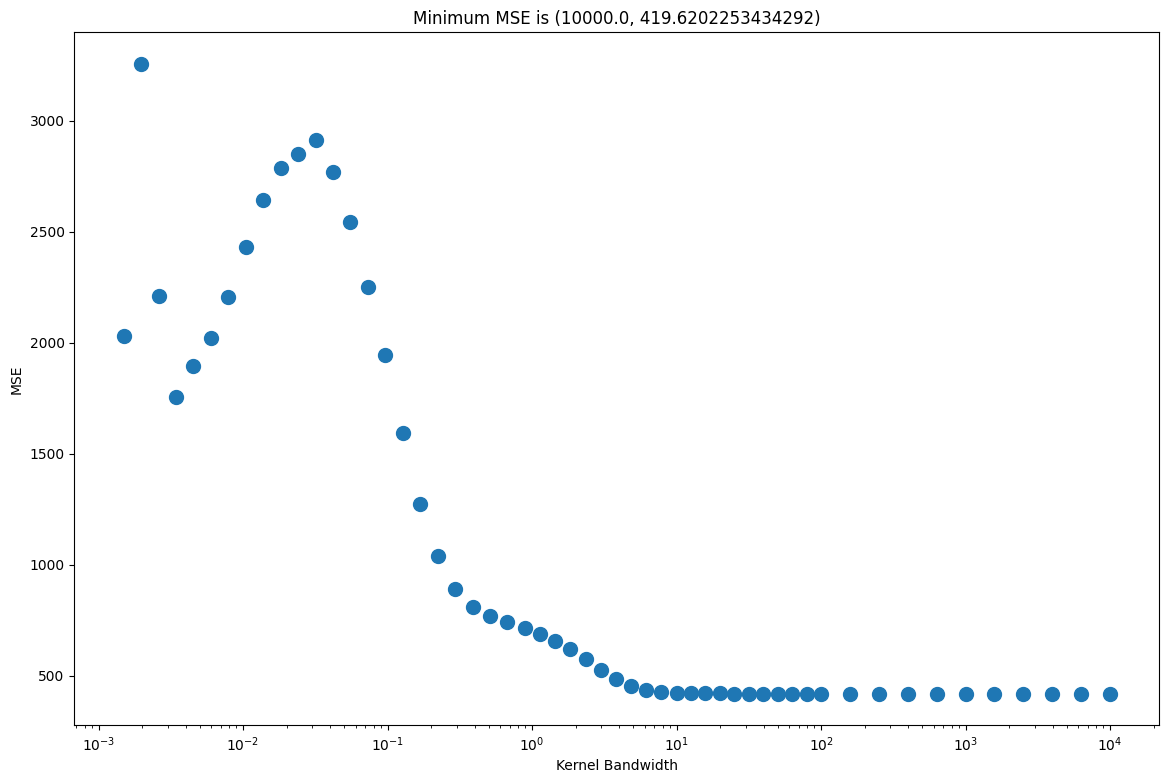

In [12]:
fig, ax = plt.subplots(figsize=(14,9))
mses.plot(kind="scatter", x="bw", y="mse", ax=ax, s=100)
ax.set_xscale("log")
ax.set_ylabel("MSE")
ax.set_xlabel("Kernel Bandwidth")
ax.set_title(f"Minimum MSE is {mses.iloc[np.argmin(mses.mse), 1], np.argmin(mses.mse)}")

/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3295/1837747864.py:13: RuntimeWarning: invalid value encountered in divide
  total_local_errors = np.sqrt(np.nanmean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3295/1837747864.py:14: RuntimeWarning: invalid value encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


12.750142619548306 0.0007912 inf


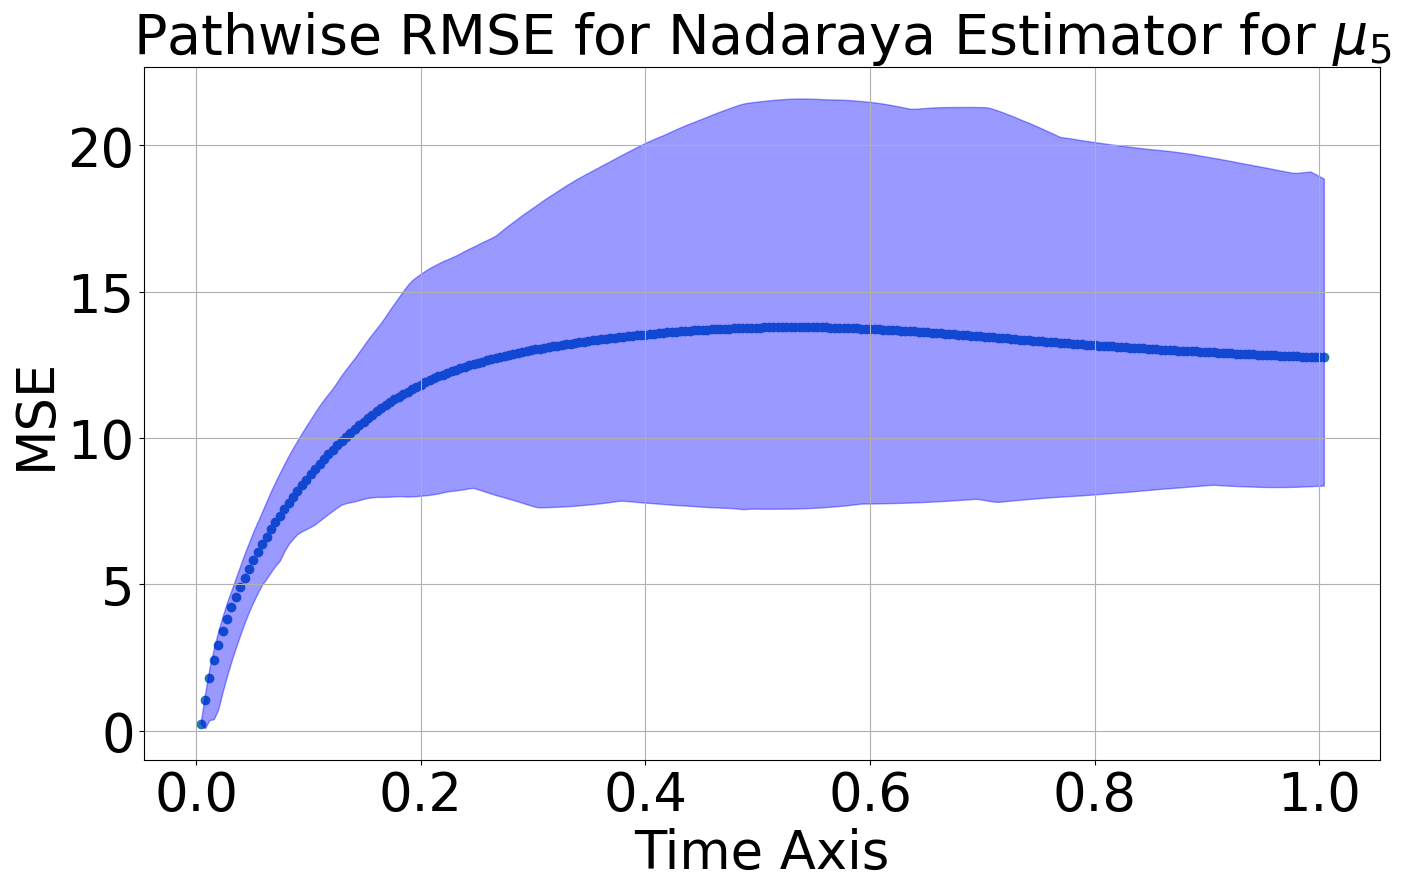

Final time cumulative MSE local-time error 12.750142619548306 with IQR ((8.377256941246838, 18.858891400837706))at bw 0.0007912 for 0.75FConst

12.721850437605475 0.0010446 12.750142619548306


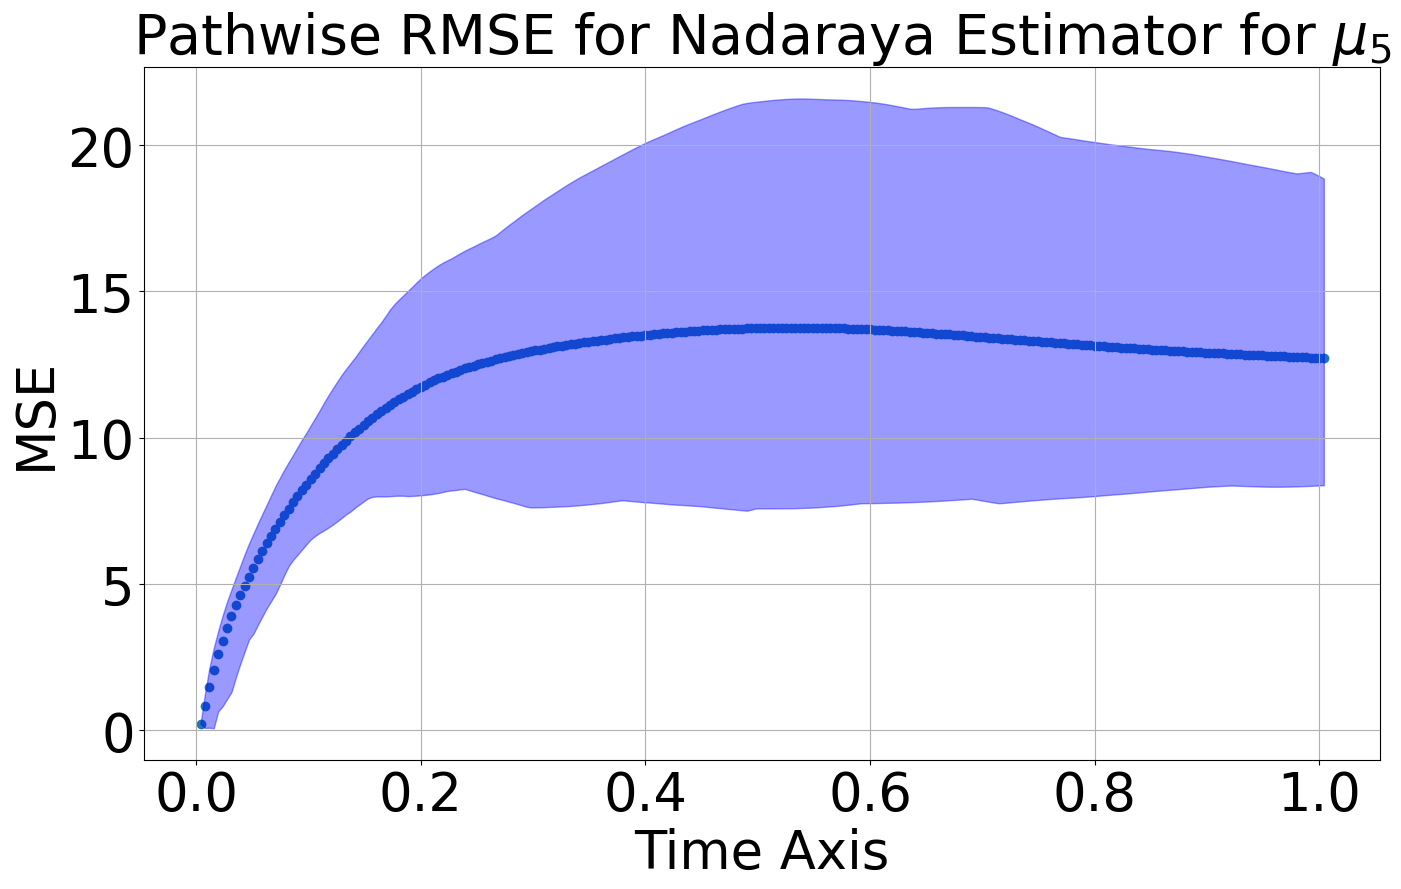

Final time cumulative MSE local-time error 12.721850437605475 with IQR ((8.377376125774841, 18.859307112208004))at bw 0.0010446 for 0.75FConst

12.222210821393071 0.0013793 12.721850437605475


/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3295/1837747864.py:13: RuntimeWarning: divide by zero encountered in divide
  total_local_errors = np.sqrt(np.nanmean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
/var/folders/68/vrxg2n311sz1gs264pkys2zh0000gn/T/ipykernel_3295/1837747864.py:14: RuntimeWarning: divide by zero encountered in divide
  all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)


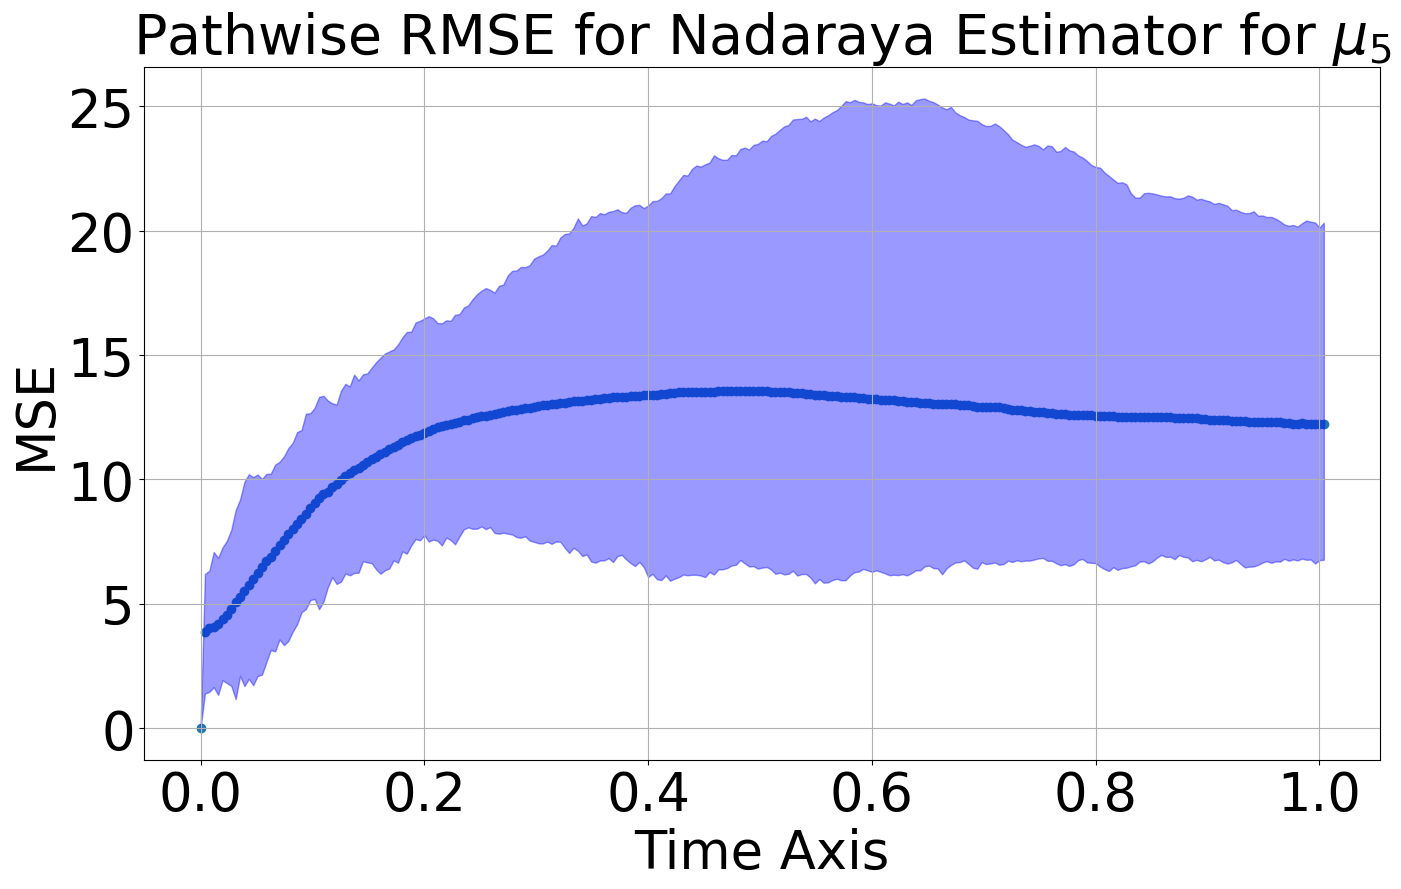

Final time cumulative MSE local-time error 12.222210821393071 with IQR ((6.774702573002418, 20.32275868467117))at bw 0.0013793 for 0.75FConst

12.562929077920845 0.0018211 12.222210821393071
11.908665529976918 0.0024046 12.222210821393071


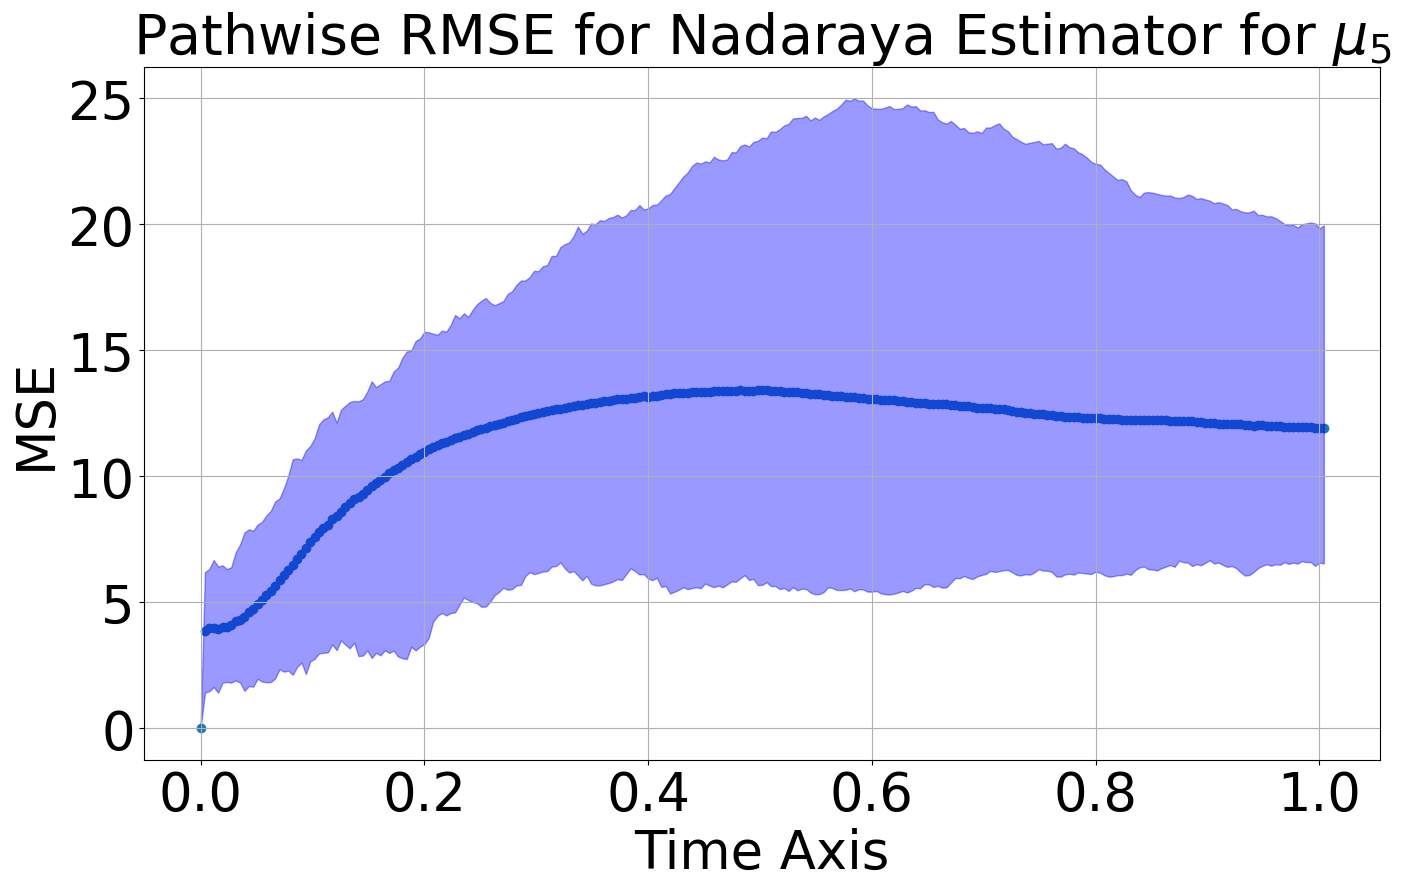

Final time cumulative MSE local-time error 11.908665529976918 with IQR ((6.539252749018993, 19.9450547127706))at bw 0.0024046 for 0.75FConst

11.540004525681896 0.0031749 11.908665529976918


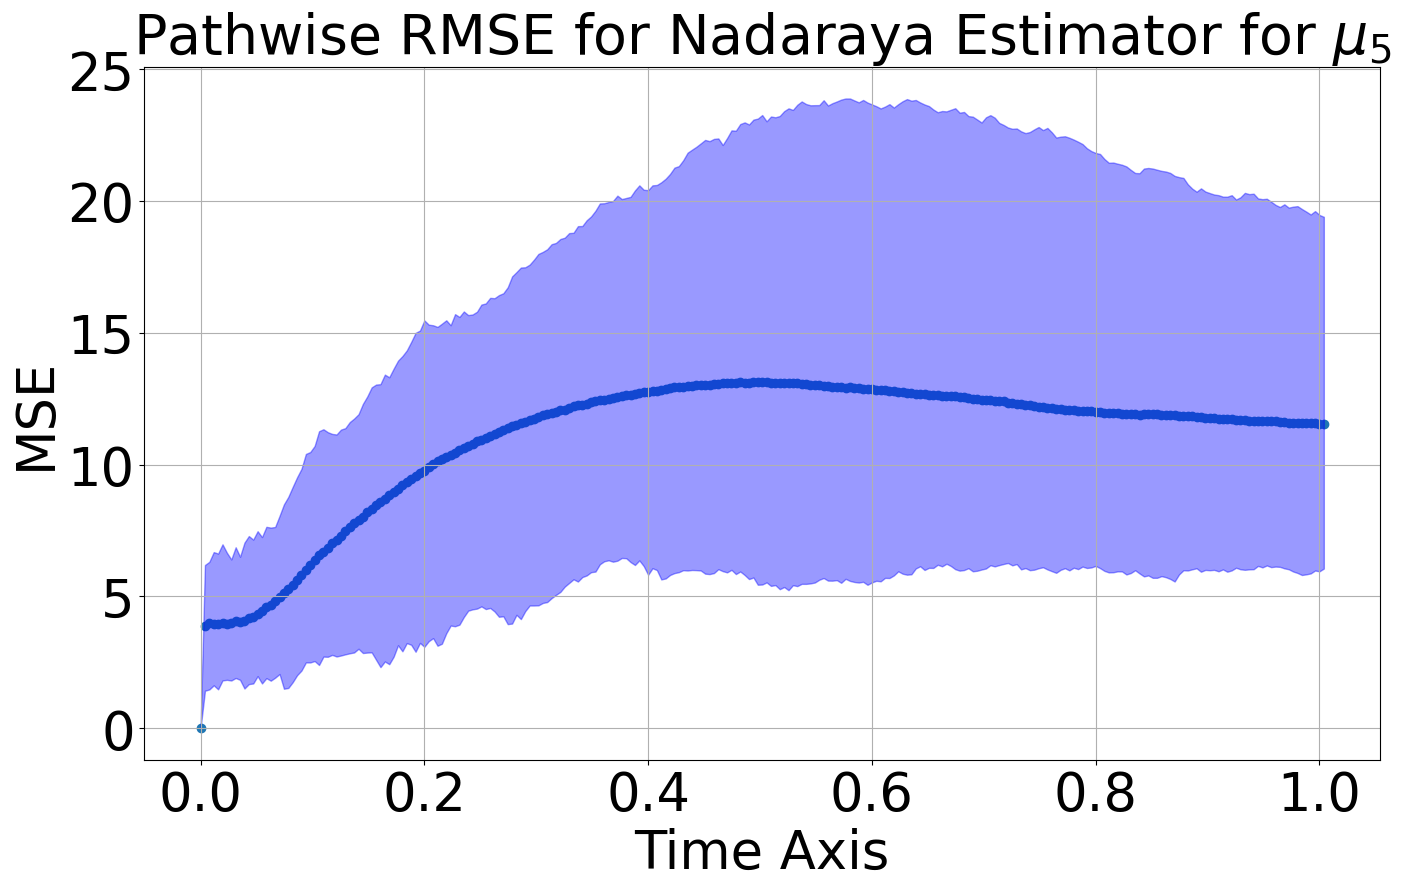

Final time cumulative MSE local-time error 11.540004525681896 with IQR ((6.0546120529301675, 19.393245179096866))at bw 0.0031749 for 0.75FConst

10.952828437951073 0.0041919 11.540004525681896


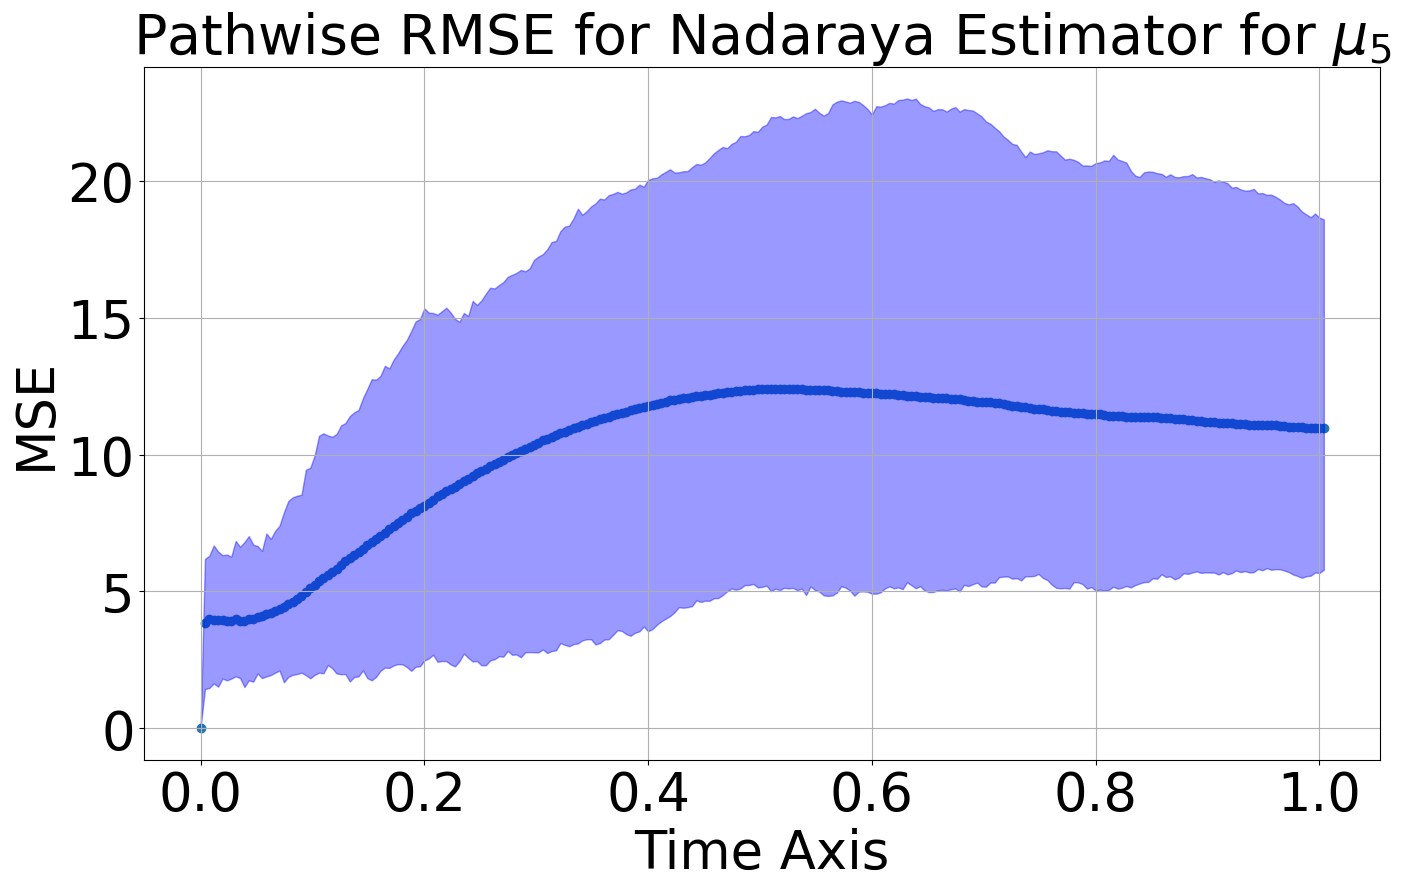

Final time cumulative MSE local-time error 10.952828437951073 with IQR ((5.789491752892742, 18.588861631754614))at bw 0.0041919 for 0.75FConst

10.14717438481574 0.0055348 10.952828437951073


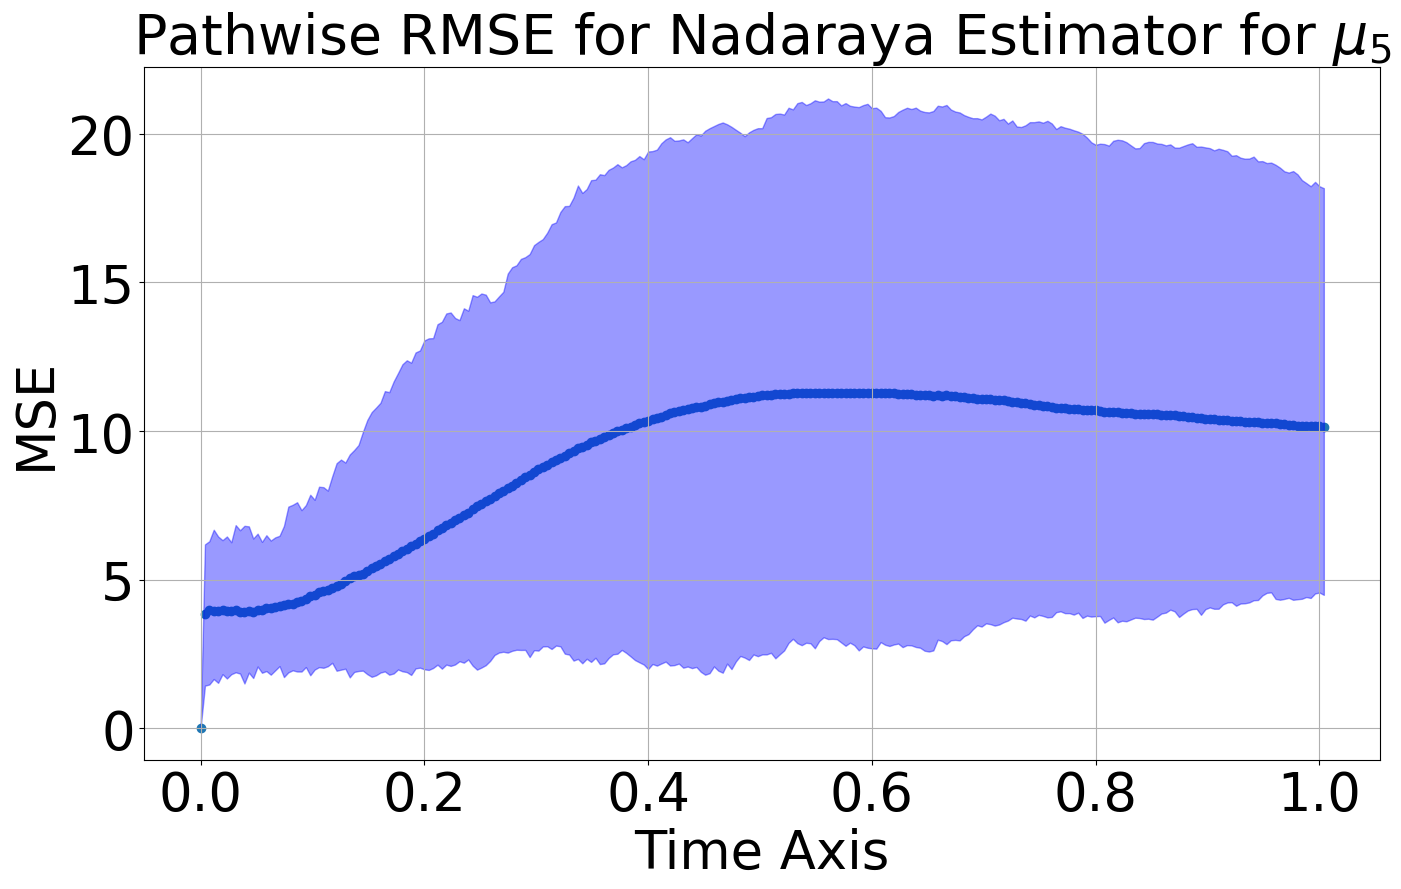

Final time cumulative MSE local-time error 10.14717438481574 with IQR ((4.487636715139016, 18.170806558715995))at bw 0.0055348 for 0.75FConst

9.072070148866663 0.0073079 10.14717438481574


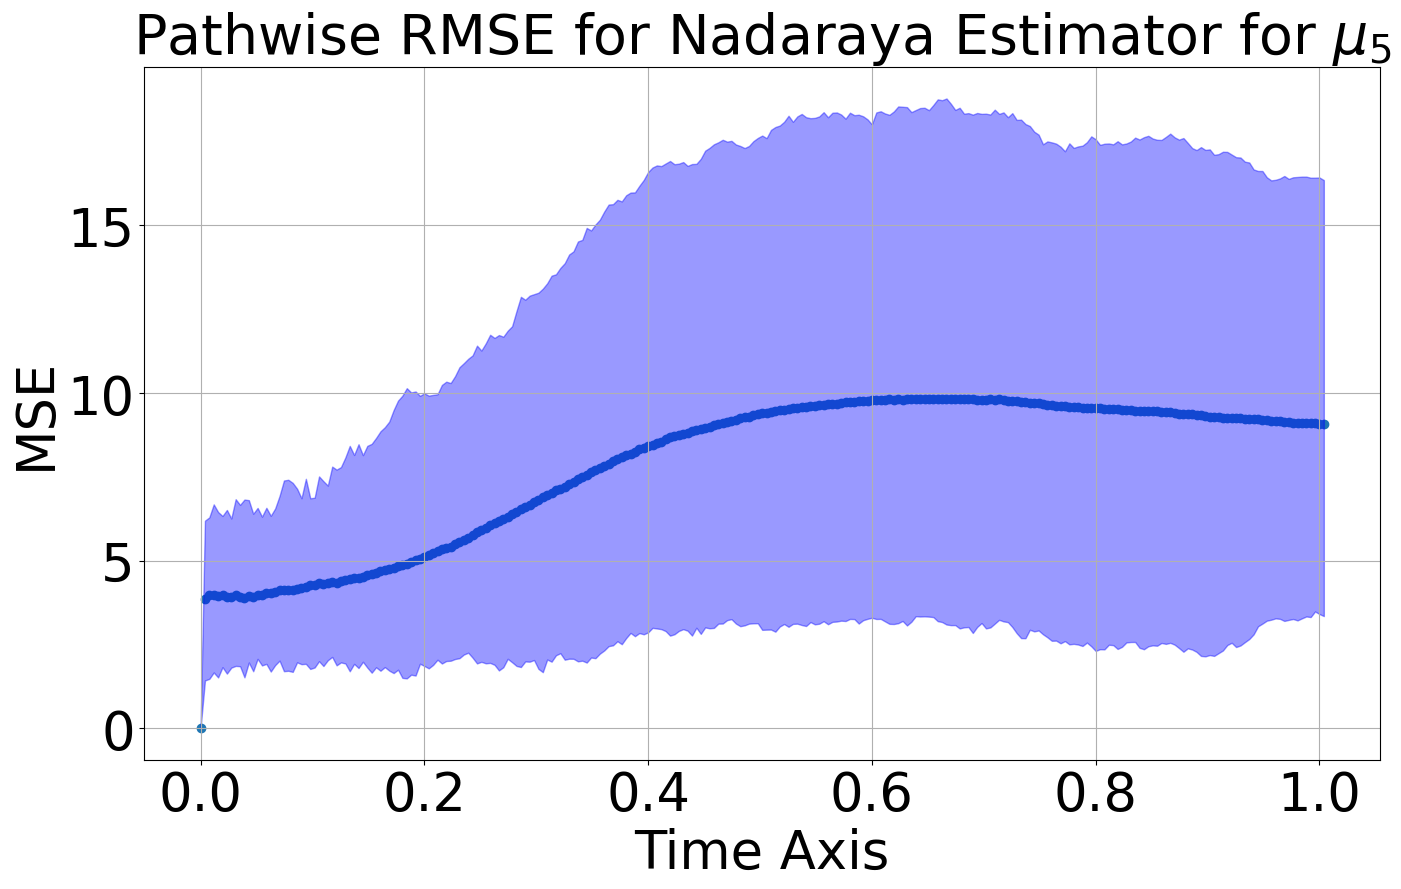

Final time cumulative MSE local-time error 9.072070148866663 with IQR ((3.3455222704098952, 16.351775690661885))at bw 0.0073079 for 0.75FConst

7.20487973326126 0.009649 9.072070148866663


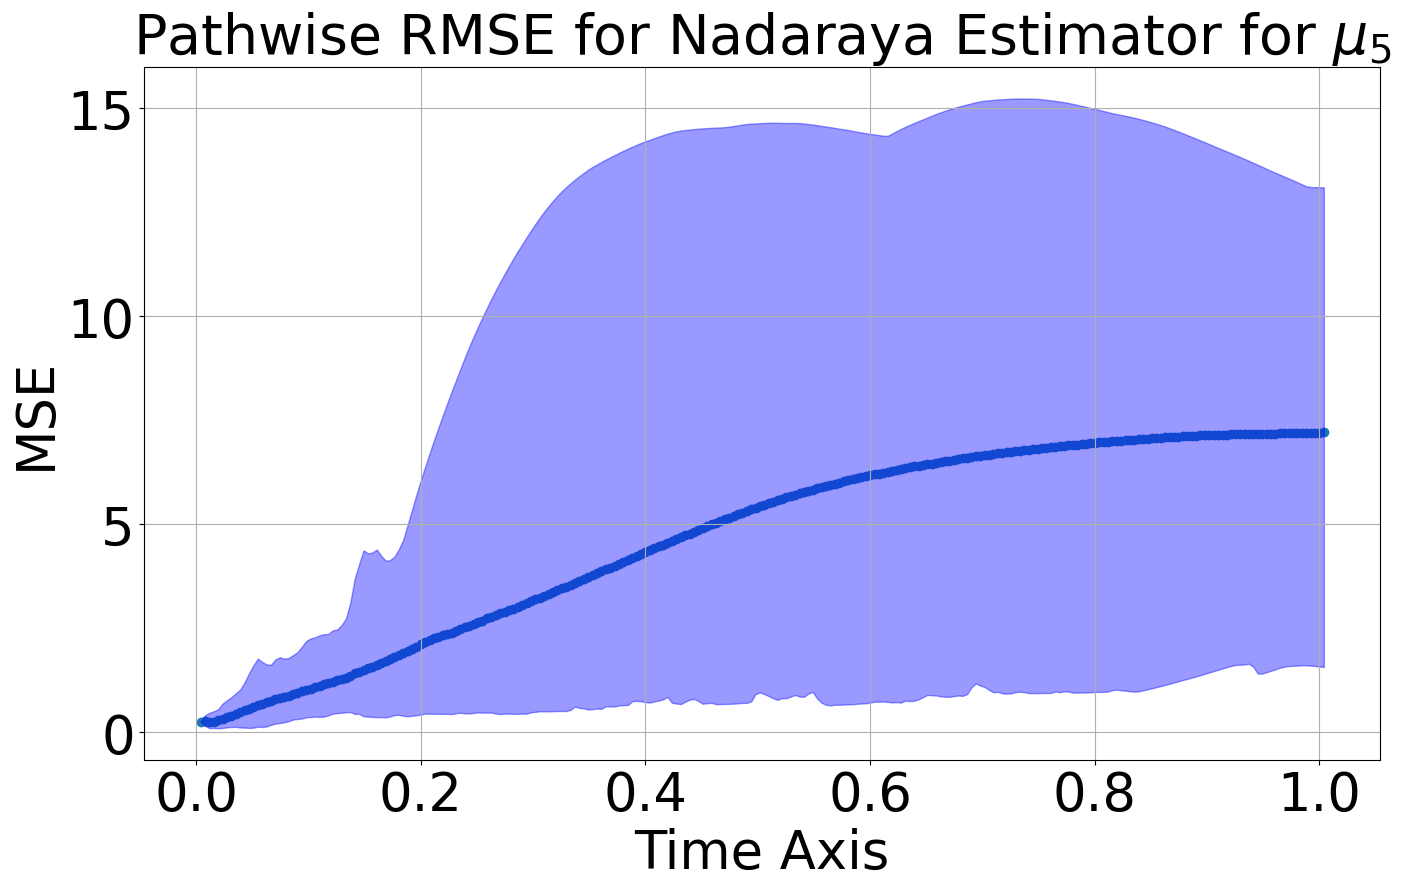

Final time cumulative MSE local-time error 7.20487973326126 with IQR ((1.5645707250655763, 13.09904227946263))at bw 0.009649 for 0.75FConst

5.933711585354026 0.0127401 7.20487973326126


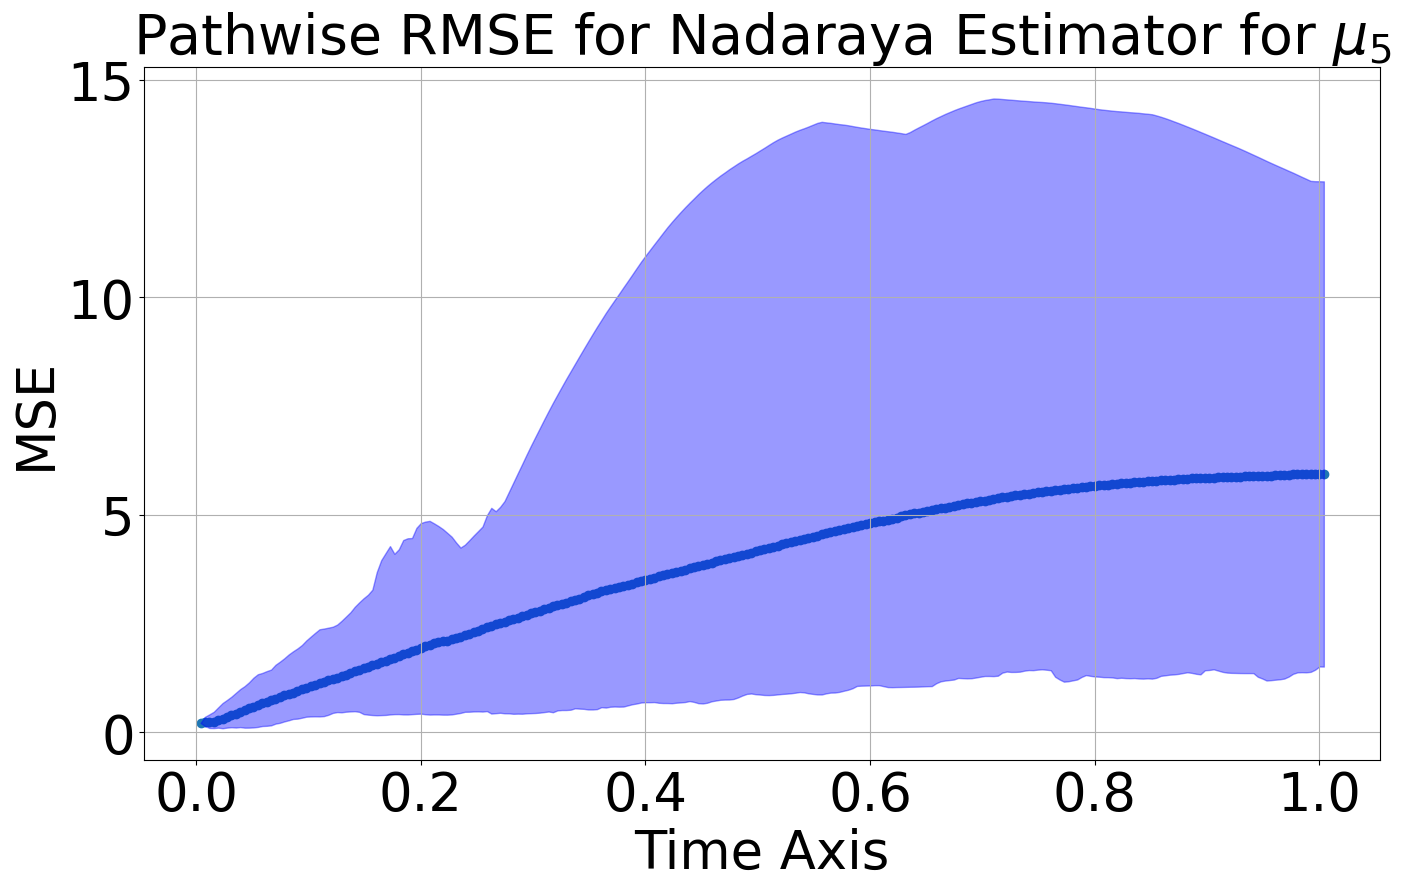

Final time cumulative MSE local-time error 5.933711585354026 with IQR ((1.506660837241401, 12.663528642539939))at bw 0.0127401 for 0.75FConst

4.968609632152454 0.0168214 5.933711585354026


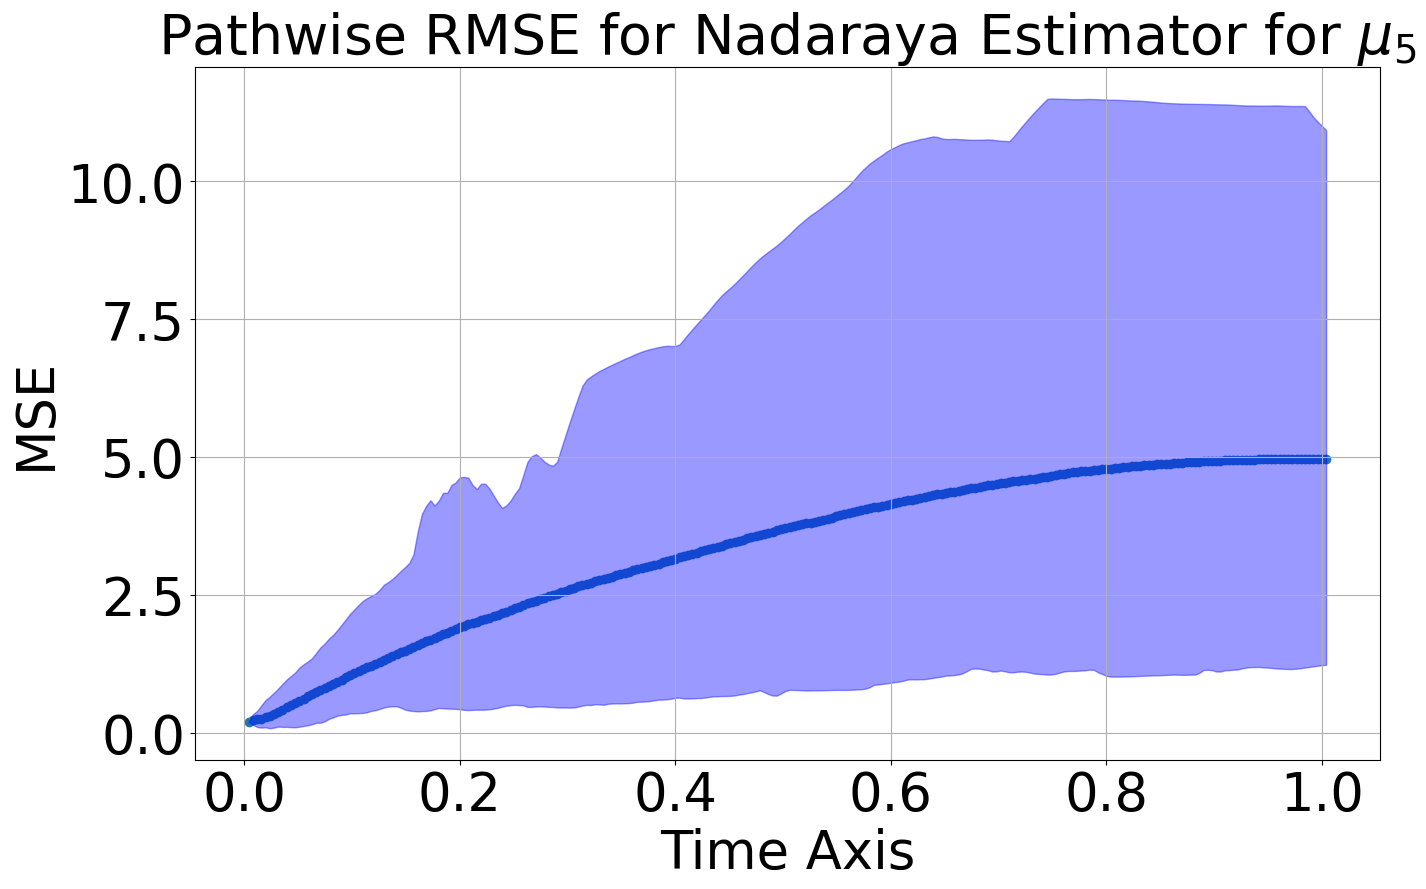

Final time cumulative MSE local-time error 4.968609632152454 with IQR ((1.2320936508389075, 10.92824658978615))at bw 0.0168214 for 0.75FConst

4.693592788781943 0.0222102 4.968609632152454


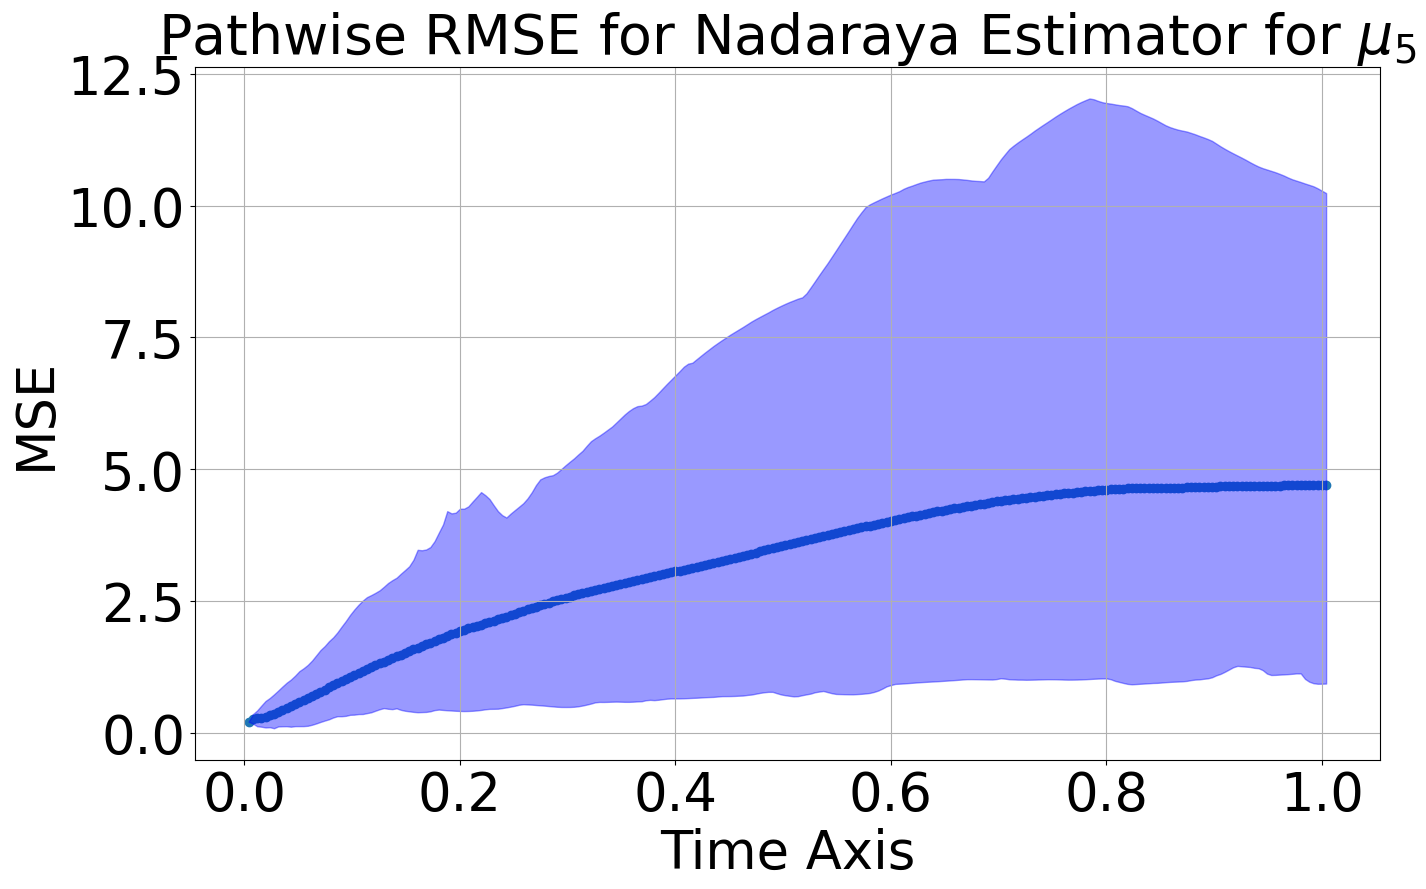

Final time cumulative MSE local-time error 4.693592788781943 with IQR ((0.9320190885600231, 10.23652177584143))at bw 0.0222102 for 0.75FConst

4.535484072910597 0.0293252 4.693592788781943


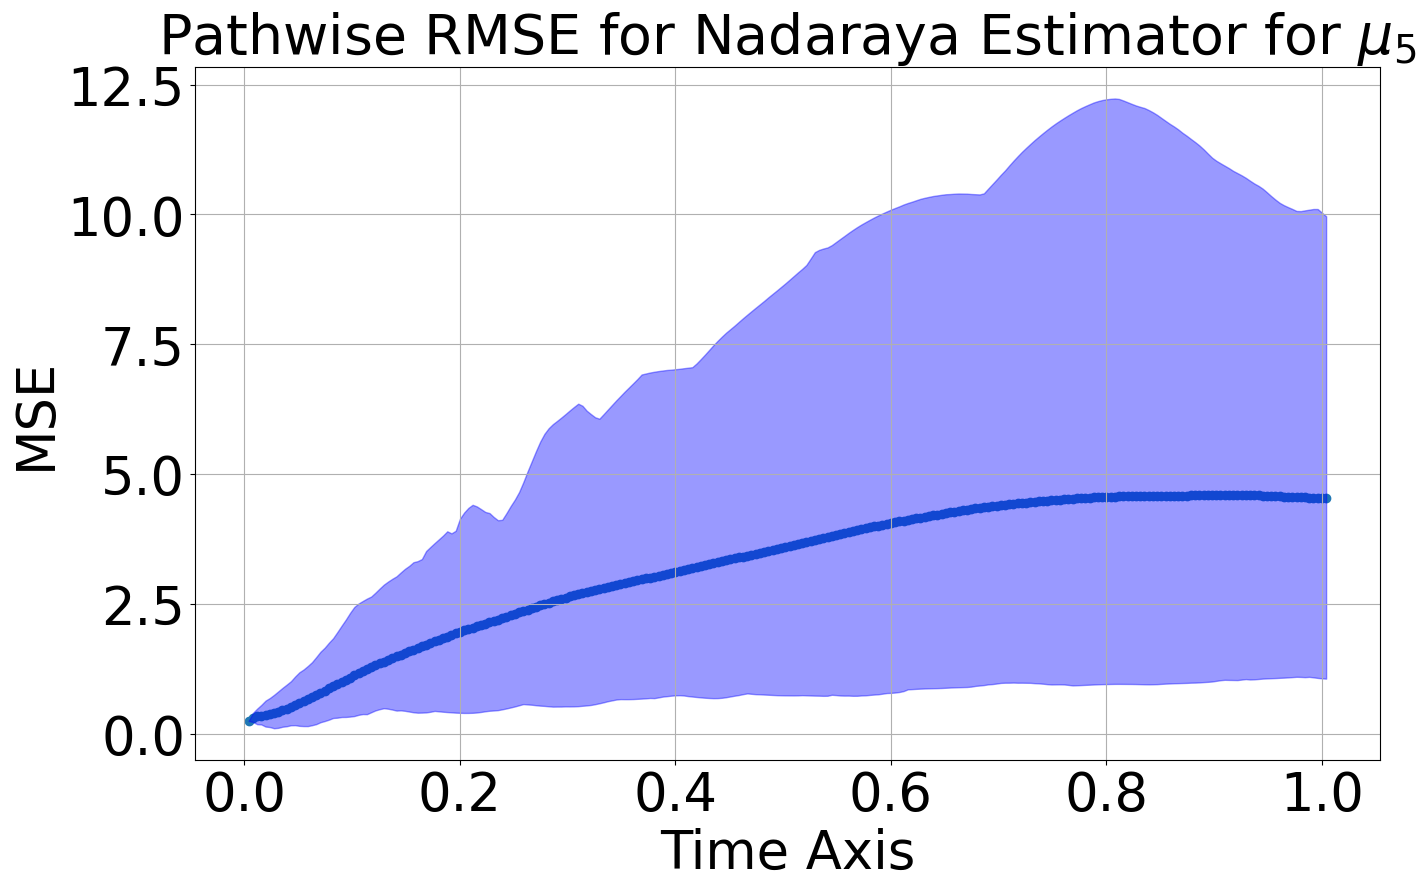

Final time cumulative MSE local-time error 4.535484072910597 with IQR ((1.0573165584987831, 9.965228670421618))at bw 0.0293252 for 0.75FConst

7.249804289824983 0.0387196 4.535484072910597
7.227609960138873 0.0511235 4.535484072910597
4.61572526814778 0.067501 4.535484072910597
4.723644451314791 0.0891251 4.535484072910597


In [13]:
curr_rmse = np.inf
toSave = False
i = 0
for file in zip(*[true_files, local_files, bws]):
    bw = file[-1]
    all_true_states = np.load(file[0])
    all_local_states = np.load(file[1])
    if all_local_states.shape[0] != 2: continue
    if (len(all_true_states.shape) == len(all_local_states.shape) == 4):
        time_steps = np.linspace(config.t0,config.deltaT*all_true_states.shape[2],all_true_states.shape[2])
        all_global_errors = np.sum(np.power(all_true_states- all_local_states,2), axis=-1)
        all_global_errors=all_global_errors.reshape(-1, all_global_errors.shape[-1])            # (K, N, T)
        total_local_errors = np.sqrt(np.nanmean(all_global_errors, axis=(0)))/np.sqrt(time_steps)
        all_paths_err = np.sqrt(all_global_errors)/np.sqrt(time_steps)
        total_local_errors[total_local_errors==np.inf] = 0.
        all_paths_err[all_paths_err==np.inf] = 0.
        total_local_errors_minq, total_local_errors_maxq  = np.quantile(all_paths_err, q=[0.005, 0.995], axis=0) # (T,)
        print(total_local_errors[-1], bw, curr_rmse)
        i += 1
        if total_local_errors[-1]  < curr_rmse:
            curr_rmse = total_local_errors[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            plt.grid(True)
            ax.scatter(time_steps, total_local_errors)
            plt.fill_between(time_steps,y1=total_local_errors_minq, y2=total_local_errors_maxq, color="blue", alpha=0.4)
            ax.set_title(rf"Pathwise RMSE for Nadaraya Estimator for $\mu_5$",fontsize=40)
            ax.set_ylabel("MSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((root_dir + f"DiffusionModelPresentationImages/IIDNadaraya/8DLnzLessData/IIDNadaraya_{config.ndims}DLnz_DriftTrack_{round(bw, 6)}bw_{config.forcing_const}FConst_{config.forcing_const}FConst_{round(total_local_errors_minq[-1], 8)}_MinIQR_{round(total_local_errors[-1], 8)}MeanIQR_{round(total_local_errors_maxq[-1], 8)}_MaxIQR").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative MSE local-time error {total_local_errors[-1]} with IQR ({total_local_errors_minq[-1], total_local_errors_maxq[-1]})at bw {bw} for {config.forcing_const}FConst\n")

In [14]:
from utils.resource_logger import wallclock_and_system_metrics
data = wallclock_and_system_metrics(config.nadaraya_resource_logging_path, inclusive=False)
data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/src/generative_modelling/resource_logging/trained_rec_PM_ST_1000FTh_MLP_2LFac_NSTgtNFMReg_8DLnz_750e-01FConst_VPSDE_T256_Ndiff10000_Tdiff1000e+00_DiffEmbSz64_ResLay10_ResChan8_DiffHdnSz64_TrueHybd_TrueWghts_t00_dT3906e-03_MLP_H4_CUp20_tl110.json.json'